In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os

import awkward as ak
import uproot
import numpy as np
import glob
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
from coffea import hist, processor
# register our candidate behaviors
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

from functools import partial

from tools.helpers import get_four_vec_fromPtEtaPhiM, match

from yahist import Hist1D, Hist2D

import json

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import mplhep as hep

plt.style.use(hep.style.CMS)  # or ATLAS/LHCb

In [3]:
from tools.helpers import dasWrapper
from analysis.tagger import desired_output

redirector_ucsd = 'root://xcache-redirector.t2.ucsd.edu:2042/'

# maybe we'll need the number of events for weighting, but not at the moment
def get_nevents(name):
    res = dasWrapper(name, query='summary')
    return json.loads(res[0])[0]['nevents']


In [108]:
samples = [
    '/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
    #'/ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    #'/ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
]

tt_samples = [
    '/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
]

QCD_samples = [
    #'/QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/QCD_bEnriched_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
]

W_samples = [
    '/W1JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/W2JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/W3JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM',
    '/W4JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM',
]

In [94]:
fileset = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in samples}

In [109]:
fileset_QCD = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in QCD_samples}
fileset_W = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)] for s in W_samples}
fileset_tt = {s.split('/')[1]: [redirector_ucsd+p for p in dasWrapper(s)][:10] for s in tt_samples}

In [30]:
exe_args = {
    'workers': 12,
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor

## Get the efficiencies

In [110]:
from analysis.tagger import measure_eff

output = processor.run_uproot_job(
            fileset_tt,
            "Events",
            measure_eff(accumulator=desired_output),
            exe,
            exe_args,
            chunksize=500000,
        )

Preprocessing:   0%|          | 0/20 [00:00<?, ?file/s]

Processing:   0%|          | 0/59 [00:00<?, ?chunk/s]

In [111]:
def get_efficiency(region, process, mass_range=slice(100,150)):

    pt_bins  = hist.Bin('pt', r'$p_{T} \ (GeV)$', [200, 300, 400, 600, 800])
    eta_bins = hist.Bin('eta', r'$\eta$', 3, 0, 2.4)

    inclusive = output[region][process].rebin('pt', pt_bins).rebin('eta', eta_bins)
    tagged = output[region+'_tagged'][process].rebin('pt', pt_bins).rebin('eta', eta_bins)

    h1 = Hist2D.from_bincounts(
        inclusive.integrate('mass', int_range=mass_range).sum('phi', 'dataset').values()[()].T,
        (
            inclusive.axis('pt').edges(),
            inclusive.axis('eta').edges(),
        )
    )
    
    h2 = Hist2D.from_bincounts(
        tagged.integrate('mass', int_range=mass_range).sum('phi', 'dataset').values()[()].T,
        (
            tagged.axis('pt').edges(),
            tagged.axis('eta').edges(),
        )
    )
    

    return h2.divide(h1)

In [112]:
# check that stuff actually ran

output['0b'].sum('pt', 'eta', 'phi', 'mass').values()

{('TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',): 80574.0,
 ('TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8',): 70043.0}

TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8
TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8


(<matplotlib.image.PcolorImage at 0x7efdc845f9a0>, <AxesSubplot:>)

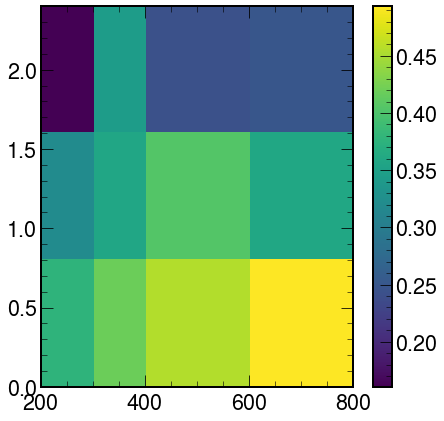

In [114]:
for s in fileset_tt.keys():
    print (s)
    for b in ['0b', '1b', '2b', '1h']:
        #print (b)
        h = get_efficiency(b, s, mass_range=slice(0,500))
        #h.plot()

        h.to_json(os.path.expandvars("../data/htag/eff_%s_%s.json"%(s,b)))
        
        #del h
    
h = get_efficiency(
    '2b',
    'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8',
    mass_range=slice(0,500),
)
fig, ax = plt.subplots(1,1,figsize=(7,7))
h.plot()

(<matplotlib.image.PcolorImage at 0x7efdc841f730>, <AxesSubplot:>)

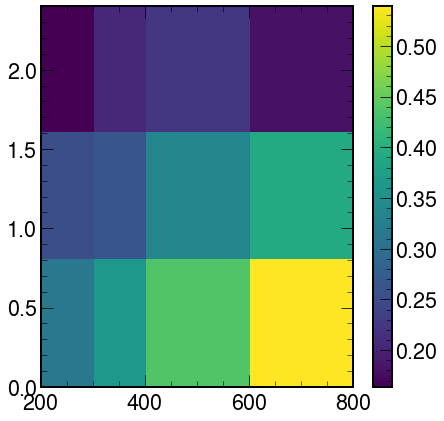

In [115]:
h = get_efficiency(
    '2b',
    'TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8',
    mass_range=slice(0,500),
)
fig, ax = plt.subplots(1,1,figsize=(7,7))
h.plot()

## Apply the efficiency

In [7]:
effs = {}
for s in fileset.keys():
    effs[s] = {}
    print (s)
    for b in ['0b', '1b', '2b', '1h']:
        #print (b)
        #h = get_efficiency(b, s, mass_range=slice(0,500))
        #h.plot()
        effs[s][b] = Hist2D.from_json(os.path.expandvars("../data/htag/eff_%s_%s.json"%(s,b)))

ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8
ZJetsToNuNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8
ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8


(<matplotlib.image.PcolorImage at 0x7efdfa990550>, <AxesSubplot:>)

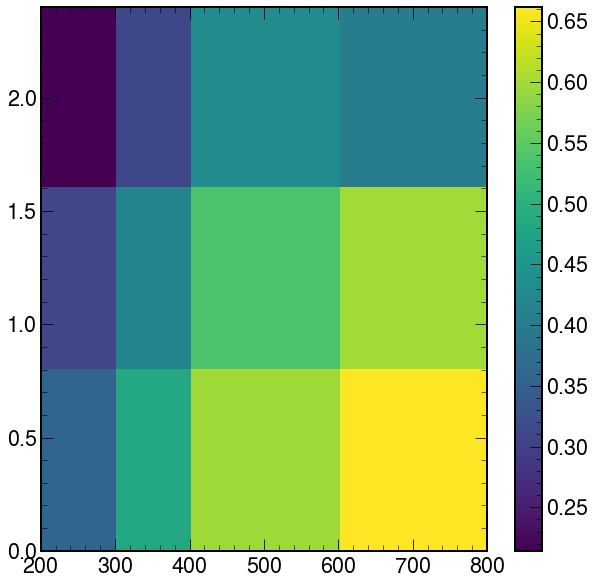

In [25]:
effs['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8']['1h'].plot()

In [9]:
np.isnan(sum(sum(effs['ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8']['1h'].counts)))

True

In [10]:
from tools.helpers import yahist_2D_lookup
yahist_2D_lookup(
    effs['ZJetsToNuNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8']['0b'],
    ak.Array([[700]]),
    ak.Array([[2.]]),
)

<Array [[0.00195]] type='1 * var * float64'>

In [96]:
from analysis.tagger import apply_eff, desired_output

output = processor.run_uproot_job(
            fileset,
            "Events",
            apply_eff(
                accumulator=desired_output,
                effs = effs,
            ),
            exe,
            exe_args,
            chunksize=500000,
        )

Processing:   0%|          | 0/103 [00:00<?, ?chunk/s]

### Closure and sanity checks

Make sure that the method closes in pt, and gives reasonable agreement in the mass distribution.


In [97]:
# if inclusive number below is nan we have a bug in applying the efficiencies.
output['inclusive'].sum('pt', 'eta', 'phi', 'mass').values()

{('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): 27094.156602625975,
 ('ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8',): 51310.84863384371}

In [98]:
# inclusive and tagged numbers should agree within percent level
output['tagged'].sum('pt', 'eta', 'phi', 'mass').values()

{('ZJetsToNuNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8',): 27094.0,
 ('ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8',): 51369.0}

<AxesSubplot:>

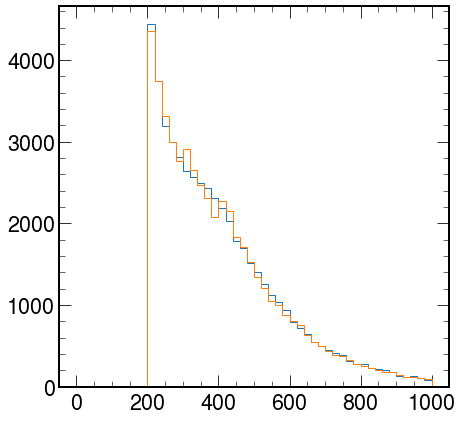

In [100]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

h1 = Hist1D.from_bincounts(
        output['tagged']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].sum('phi', 'mass', 'eta', 'dataset').values()[()],
        output['tagged']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].axis('pt').edges(),
    )

h2 = Hist1D.from_bincounts(
        output['inclusive']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].sum('phi', 'mass', 'eta', 'dataset').values()[()],
        output['inclusive']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].axis('pt').edges(),
    )
h1.plot()
h2.plot()

<AxesSubplot:>

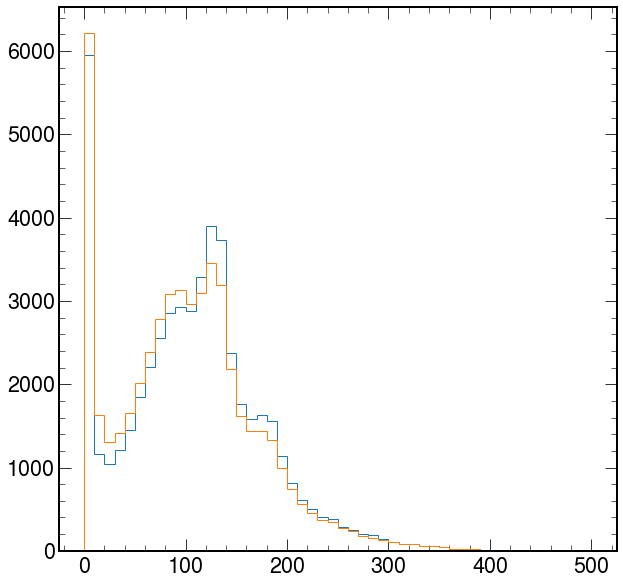

In [101]:
h1 = Hist1D.from_bincounts(
        output['tagged']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].sum('phi', 'pt', 'eta', 'dataset').values()[()],
        output['tagged']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].axis('mass').edges(),
    )

h2 = Hist1D.from_bincounts(
        output['inclusive']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].sum('phi', 'pt', 'eta', 'dataset').values()[()],
        output['inclusive']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].axis('mass').edges(),
    )
h1.plot()
h2.plot()

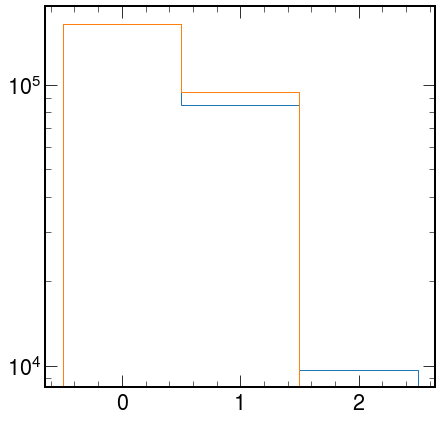

In [102]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

h1 = Hist1D.from_bincounts(
        output['NH_true']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].sum('dataset').values()[()],
        output['NH_true']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].axis('multiplicity').edges(),
    )

h2 = Hist1D.from_bincounts(
        output['NH_weight']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].sum('dataset').values()[()],
        output['NH_weight']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].axis('multiplicity').edges(),
    )
h1.plot()
h2.plot()

ax.set_yscale('log')

### Compare prediction of tagged jets in the interesting mass window

In [106]:
output['inclusive']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].integrate('mass', int_range=slice(100,150)).sum('phi', 'pt', 'eta', 'dataset').values()[()]

14888.00129196727

In [105]:
output['tagged']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].integrate('mass', int_range=slice(100,150)).sum('phi', 'pt', 'eta', 'dataset').values()[()]

16166.0

In [107]:
16166.0/14888.0

1.085840945728103

In [41]:
test_eff = ak.Array([[0.1,0.2], [0.15], []])
1-ak.prod(1-test_eff, axis=1)

<Array [0.28, 0.15, 0] type='3 * float64'>

In [43]:
np.zeros_like(ak.num(test_eff))

<Array [0, 0, 0] type='3 * int64'>

In [104]:
output['NH_true']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].values()

{('ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8',): array([165457.,  84570.,   9685.])}

In [103]:
output['NH_weight']['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'].values()

{('ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8',): array([165302.14350765,  94695.85649235,      0.        ])}

In [80]:
54281.68960112/(5.3884000e+04+1.7600000e+02)

1.0041008065320014

## WIP

In [82]:
def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
       Version from Jonathan Guiang: https://gist.github.com/jkguiang/279cb4d2e68e64148afc62274df09f18
    """
    return a * (1.0 - (0.299 * r + 0.587 * g + 0.114 * b))

def bin_text(counts, x_edges, y_edges, axes, cbar, errors=None, size=10, fmt=":0.2e"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
       Version from Jonathan Guiang: https://gist.github.com/jkguiang/279cb4d2e68e64148afc62274df09f18
    """
    show_errors = (type(errors) != type(None))
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2
    
    if show_errors:
        label_template = r"{0"+fmt+"}\n$\pm{1:0.2f}\%$"
    else:
        errors = np.zeros(counts.shape)
        label_template = r"{0"+fmt+"}"
        
    xyz = np.c_[        
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
        errors.flatten()
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, count, err), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            label_template.format(count, err),
            color=color,
            ha="center",
            va="center",
            fontsize=size,
            wrap=True,
        )

    return

In [83]:
h2.divide(h1).counts

array([[0.00573215, 0.00499625, 0.00743898, 0.01090472],
       [0.00275938, 0.00476695, 0.00593952, 0.00717526],
       [0.00184162, 0.00272975, 0.00470711, 0.00598802],
       [0.00391696, 0.00114329, 0.00357302, 0.00382696],
       [0.        , 0.00122624, 0.00139938, 0.00299513],
       [0.00091075, 0.        , 0.00152555, 0.00280505]])

In [85]:
h2.edges[0]

array([200., 300., 400., 600., 800.])